input: embeddings, metadata (genus, family, host); embeddings are mapped with headers and headers are aligned with metadata by accession number

output: supervised MLP model that predicts genus, family, host based on embeddings

dataset: separate 90% of them to train and 10% of them to validate

loss function: try hierarchical loss for the taxonomic labels


# MLP training

## megaDNA

In [1]:
import numpy as np
import pandas as pd

In [ ]:
embeddings_megadna = np.load("../results/embeddings_megaDNA.npy")
headers_megadna = np.load("../results/headers_megaDNA.npy")
metadata_cleaned_131k = pd.read_csv("../dataset/metadata_cleaned_131k.tsv", sep="\t")

In [5]:
headers_megadna

array(['AY319521 Salmonella phage SopEPhi, complete sequence.',
       'AC171169 Escherichia phage H8 clone h8_phage, WORKING DRAFT SEQUENCE.',
       'AY576273 Alphaproteobacteria phage PhiJL001, complete genome.',
       ..., 'PP856269 Escherichia phage UFJF_EcSW4, complete genome.',
       'PQ261042 Pseudomonas phage Minga_mokiny_4, complete genome.',
       'PQ374047 Salmonella phage vB_SeTS_UALMA_PCST1, partial genome.'],
      shape=(8069,), dtype='<U394')

Epoch 1/20
Train Loss: 5.6930, Val Loss: 3.0972
Train Accuracies: {'genus': '0.4999', 'family': '0.8525', 'host': '0.5295'}
Val Accuracies: {'genus': '0.6518', 'family': '0.9405', 'host': '0.6753'}
Epoch 2/20
Train Loss: 2.7776, Val Loss: 2.1679
Train Accuracies: {'genus': '0.6851', 'family': '0.9503', 'host': '0.6903'}
Val Accuracies: {'genus': '0.7546', 'family': '0.9665', 'host': '0.7534'}
Epoch 3/20
Train Loss: 2.0311, Val Loss: 1.7252
Train Accuracies: {'genus': '0.7491', 'family': '0.9694', 'host': '0.7356'}
Val Accuracies: {'genus': '0.8240', 'family': '0.9851', 'host': '0.7794'}
Epoch 4/20
Train Loss: 1.6063, Val Loss: 1.4738
Train Accuracies: {'genus': '0.8034', 'family': '0.9767', 'host': '0.7660'}
Val Accuracies: {'genus': '0.8463', 'family': '0.9901', 'host': '0.7993'}
Epoch 5/20
Train Loss: 1.3286, Val Loss: 1.2943
Train Accuracies: {'genus': '0.8299', 'family': '0.9864', 'host': '0.7867'}
Val Accuracies: {'genus': '0.8736', 'family': '0.9888', 'host': '0.8055'}
Epoch 6/20

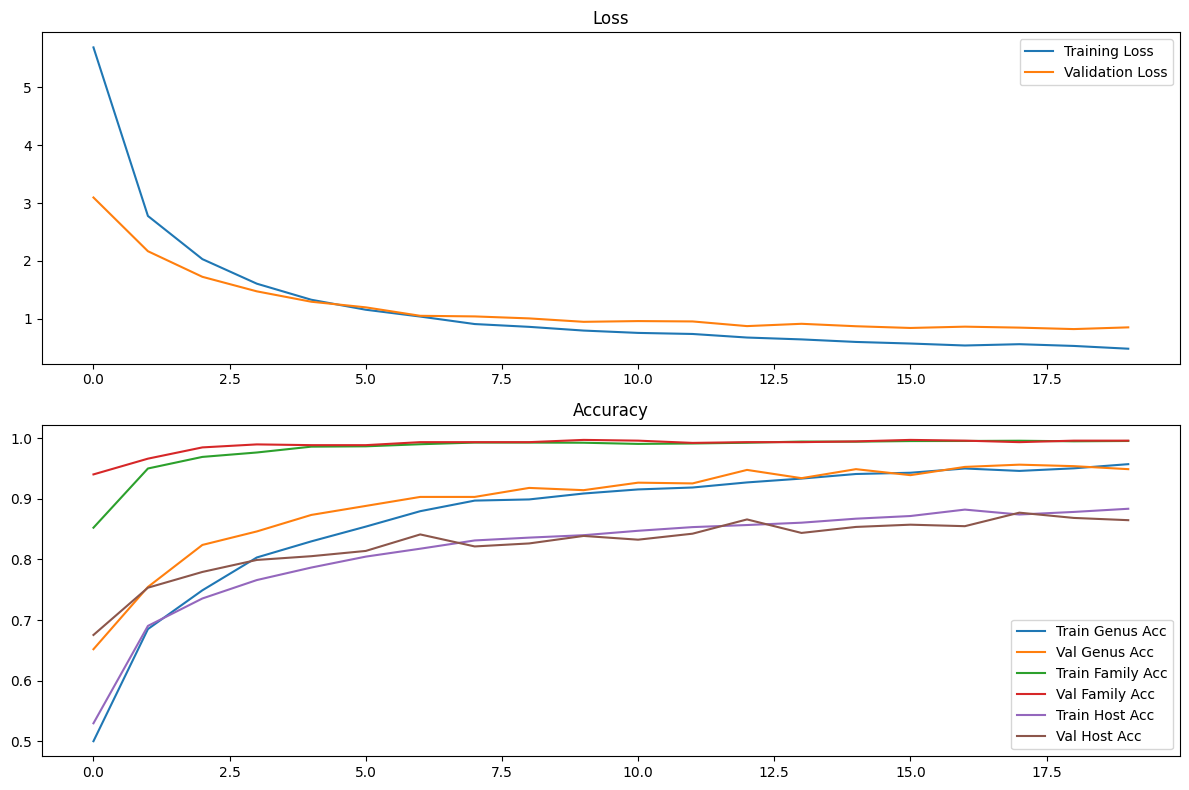

Training completed and model saved successfully!


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)


# Data preparation (same as before)
accession_numbers = [header.split()[0] for header in headers_megadna]
embeddings_df = pd.DataFrame(embeddings_megadna)
embeddings_df["Accession"] = accession_numbers
merged_data = pd.merge(embeddings_df, metadata_cleaned_131k, on="Accession")

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(merged_data.iloc[:, : embeddings_megadna.shape[1]].values)

# Encode targets
genus_encoder = LabelEncoder()
family_encoder = LabelEncoder()
host_encoder = LabelEncoder()

y_genus = genus_encoder.fit_transform(merged_data["Genus"])
y_family = family_encoder.fit_transform(merged_data["Family"])
y_host = host_encoder.fit_transform(merged_data["Host"])


# Create PyTorch Dataset
class TaxonomyDataset(Dataset):
    def __init__(self, X, y_genus, y_family, y_host):
        self.X = torch.FloatTensor(X)
        self.y_genus = torch.LongTensor(y_genus)
        self.y_family = torch.LongTensor(y_family)
        self.y_host = torch.LongTensor(y_host)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.y_genus[idx], self.y_family[idx], self.y_host[idx])


# Split data
(
    X_train,
    X_val,
    y_genus_train,
    y_genus_val,
    y_family_train,
    y_family_val,
    y_host_train,
    y_host_val,
) = train_test_split(X, y_genus, y_family, y_host, test_size=0.1, random_state=42)

# Create datasets
train_dataset = TaxonomyDataset(X_train, y_genus_train, y_family_train, y_host_train)
val_dataset = TaxonomyDataset(X_val, y_genus_val, y_family_val, y_host_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Define model
class TaxonomyMLP(nn.Module):
    def __init__(self, input_size, genus_classes, family_classes, host_classes):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.genus_classifier = nn.Linear(256, genus_classes)
        self.family_classifier = nn.Linear(256, family_classes)
        self.host_classifier = nn.Linear(256, host_classes)

    def forward(self, x):
        shared_features = self.shared_layers(x)
        return {
            "genus": self.genus_classifier(shared_features),
            "family": self.family_classifier(shared_features),
            "host": self.host_classifier(shared_features),
        }


# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaxonomyMLP(
    input_size=X.shape[1],
    genus_classes=len(genus_encoder.classes_),
    family_classes=len(family_encoder.classes_),
    host_classes=len(host_encoder.classes_),
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = {"genus": 0, "family": 0, "host": 0}
    total_samples = 0

    for batch in train_loader:
        x, y_genus, y_family, y_host = [b.to(device) for b in batch]
        optimizer.zero_grad()

        outputs = model(x)

        # Calculate losses with weights
        loss = (
            1.0 * criterion(outputs["genus"], y_genus)
            + 1.5 * criterion(outputs["family"], y_family)  # Higher weight for family
            + 1.0 * criterion(outputs["host"], y_host)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracies
        for task, output in outputs.items():
            pred = output.argmax(dim=1)
            target = {"genus": y_genus, "family": y_family, "host": y_host}[task]
            total_correct[task] += (pred == target).sum().item()

        total_samples += x.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracies = {task: correct / total_samples for task, correct in total_correct.items()}

    return avg_loss, accuracies


# Validation function
@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = {"genus": 0, "family": 0, "host": 0}
    total_samples = 0

    for batch in val_loader:
        x, y_genus, y_family, y_host = [b.to(device) for b in batch]
        outputs = model(x)

        loss = (
            1.0 * criterion(outputs["genus"], y_genus)
            + 1.5 * criterion(outputs["family"], y_family)
            + 1.0 * criterion(outputs["host"], y_host)
        )

        total_loss += loss.item()

        for task, output in outputs.items():
            pred = output.argmax(dim=1)
            target = {"genus": y_genus, "family": y_family, "host": y_host}[task]
            total_correct[task] += (pred == target).sum().item()

        total_samples += x.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracies = {task: correct / total_samples for task, correct in total_correct.items()}

    return avg_loss, accuracies


# Training loop
num_epochs = 20
best_val_loss = float("inf")
patience = 3
patience_counter = 0
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": {"genus": [], "family": [], "host": []},
    "val_acc": {"genus": [], "family": [], "host": []},
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Store metrics
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    for task in ["genus", "family", "host"]:
        history["train_acc"][task].append(train_acc[task])
        history["val_acc"][task].append(val_acc[task])

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print("Train Accuracies:", {k: f"{v:.4f}" for k, v in train_acc.items()})
    print("Val Accuracies:", {k: f"{v:.4f}" for k, v in val_acc.items()})

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
            },
            "../models/taxonomy_mlp_model.pt",
        )
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot results
plt.figure(figsize=(12, 8))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

# Plot accuracies
plt.subplot(2, 1, 2)
for task in ["genus", "family", "host"]:
    plt.plot(history["train_acc"][task], label=f"Train {task.capitalize()} Acc")
    plt.plot(history["val_acc"][task], label=f"Val {task.capitalize()} Acc")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Save encoders
import pickle

with open("../models/label_encoders.pkl", "wb") as f:
    pickle.dump(
        {
            "genus_encoder": genus_encoder,
            "family_encoder": family_encoder,
            "host_encoder": host_encoder,
            "scaler": scaler,
        },
        f,
    )

print("Training completed and model saved successfully!")